In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm
import numba as nb

from scipy.signal import savgol_filter
%matplotlib inline

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

@nb.njit()
def to_euler(x, y, z, w):
    """Dari Coursera: Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])
# Compile the to_euler
_ = to_euler(1.5352300785980803e-15, -1.3393747145983517e-15, -0.7692164172827881, 0.638988343698562)

In [54]:
class get_data_from_bag(object):
    def __init__(self, path):
        self.bag = rosbag.Bag(path)
        self.cs = self._read_msg_from_topic('/control_signal', ['t', 'action_throttle', 'action_steer',
                                                                'error_lateral', 'error_yaw','error_speed',
                                                                'actual_x','actual_y','actual_yaw','actual_speed',
                                                                'ref_x', 'ref_y', 'ref_yaw', 'ref_curvature', 'ref_speed',
                                                                'wp_idx', 'deg_ref_yaw', 'deg_actual_yaw', 'deg_error_yaw'])
        self.ar = self._read_msg_from_topic('/logging_arduino', ['t', 'steering_setpoint', 'steering_angle', 'throttle_voltage'])
        self.gnss = self._read_gnss()
        self.imu = self._read_imu('/imu', ['t', 'yaw'])
        self.ekf = self._read_msg_from_topic('/state_2d_new_new', ['t', 'yaw', 'yaw_imu', 'px', 'py', 'vx', 'vy', 'bw', 'bax', 'bay'])
        
    def _read_msg_from_topic(self, topic, columns_name):
        data = []
        for _, msg, _ in self.bag.read_messages(topics=[topic]):
            temp = []
            for name in columns_name:
                if name == 't':
                    temp.append(msg.header.stamp.to_sec())
                else:
                    nm = 'msg.' + name
                    temp.append(eval(nm))
            data.append(temp)
        return pd.DataFrame(data, columns = columns_name)
    def _read_gnss(self):
        lat0, lon0, h0 = -6.8712, 107.5738, 768
        data = []
        for _, msg, _ in self.bag.read_messages(topics='/fix'):
            temp = []
            temp.append(msg.header.stamp.to_sec())
            pos = pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0)
            temp.append(pos[0])
            temp.append(pos[1])
            temp.append(pos[2])
            temp.append(msg.position_covariance[0])
            data.append(temp)
        return pd.DataFrame(data, columns=['t', 'x', 'y', 'z', 'cov_x'])
    def _read_imu(self, topic, columns_name):
        data = []
        for _, msg, _ in self.bag.read_messages(topics=[topic]):
            temp = []
            for name in columns_name:
                if name == 't':
                    temp.append(msg.header.stamp.to_sec())
                elif name == 'yaw':
                    q = msg.orientation
                    euler = to_euler(q.x, q.y, q.z, q.w)
                    temp.append(euler[-1])
                else:
                    nm = 'msg.' + name
                    temp.append(eval(nm))
            data.append(temp)
        return pd.DataFrame(data, columns = columns_name)

In [55]:
# df = get_data_from_bag('bag/LURUS_1.bag')
df = get_data_from_bag('bag/TEST_EKF.bag')

# TAMBAHAN

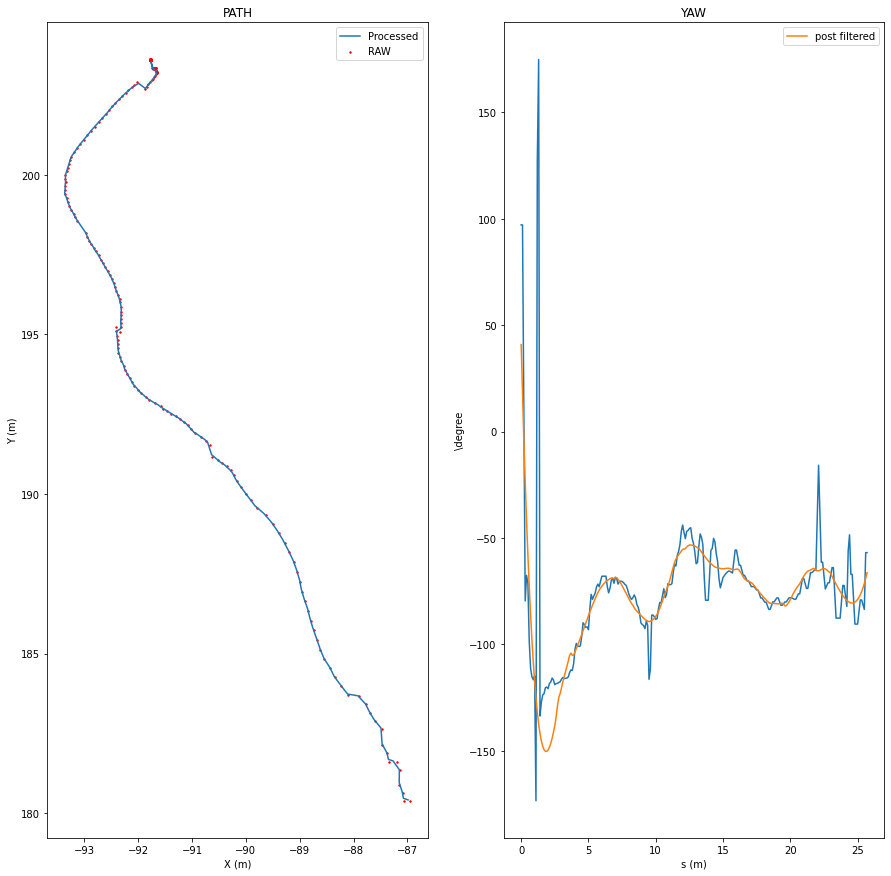

In [56]:
num_f = 51

dst = 0.1

X = np.copy(df.gnss.x)
Y = np.copy(df.gnss.y)
x = np.copy(df.gnss.x)
y = np.copy(df.gnss.y)
t = np.copy(df.gnss.t)

wp_x = [X[0]]
wp_y = [Y[0]]
wp_t = [t[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    # if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_t.append(wp_t[-1] + dst*(t[i] - wp_t[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)

wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))
act_yaw_dydx = np.copy(wp_yaw)
act_yaw_dydx_f = np.copy(wp_yaw_f)

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(1,2,2)
plt.plot(s, wp_yaw*180./np.pi)
plt.plot(s, wp_yaw_f*180./np.pi, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel(r'\degree')
plt.legend()

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

In [57]:
act_yaw_dydx_interp = np.interp(df.imu.t, wp_t, act_yaw_dydx)
act_yaw_dydx_f_interp = np.interp(df.imu.t, wp_t, act_yaw_dydx_f)
ekf_yaw = np.interp(df.imu.t, df.cs.t, wrap_angle(df.cs.actual_yaw))

In [58]:
yaw_gnss = np.zeros_like(df.gnss.x.values)
n = 1
diffx = df.gnss.x.values[n:] - df.gnss.x.values[:-n]
diffy = df.gnss.y.values[n:] - df.gnss.y.values[:-n]
yaw_gnss[n:] = np.arctan2(diffy, diffx)
yaw_gnss[:n] = yaw_gnss[n]
yaw_gnss = np.interp(df.imu.t, df.gnss.t, yaw_gnss)

In [59]:
df.ekf.t

0       1.599655e+09
1       1.599655e+09
2       1.599655e+09
3       1.599655e+09
4       1.599655e+09
            ...     
2273    1.599655e+09
2274    1.599655e+09
2275    1.599655e+09
2276    1.599655e+09
2277    1.599655e+09
Name: t, Length: 2278, dtype: float64

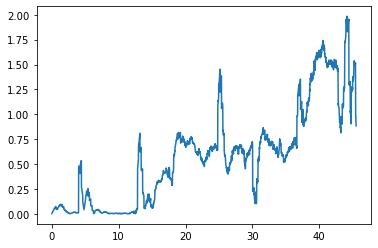

In [72]:
plt.plot(df.ekf.t - df.ekf.t[0], np.sqrt(df.ekf.vx**2 + df.ekf.vy**2))
# plt.ylim(0., 0.2)

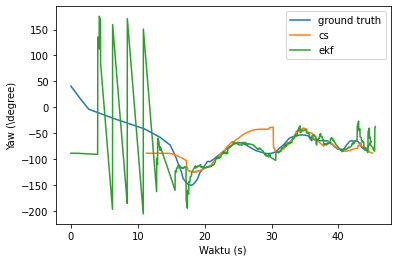

In [70]:
plt.plot(wp_t - df.gnss.t[0], wrap_angle(act_yaw_dydx_f)*180./np.pi, label='ground truth')
# plt.plot(df.imu.t-df.gnss.t[0], wrap_angle(df.imu.yaw + np.pi/2)*180./np.pi, label='Compass')
plt.plot(df.cs.t-df.gnss.t[0], wrap_angle(df.cs.actual_yaw)*180./np.pi, label='cs')
# plt.plot(df.imu.t - df.imu.t[0], yaw_gnss*180./np.pi, label='gnss dy dx')
plt.plot(df.ekf.t - df.ekf.t[0], df.ekf.yaw*180./np.pi, label='ekf')
# plt.plot(df.ekf.t - df.gnss.t[0], df.ekf.yaw*180./np.pi, label='ekf')
# plt.xlim(10., 33.)
plt.xlabel("Waktu (s)")
plt.ylabel(r"Yaw (\degree)")
plt.legend()
# plt.savefig('gt_vs_compass.png', dpi=600)
# plt.ylim(-180., 180.)
plt.show()

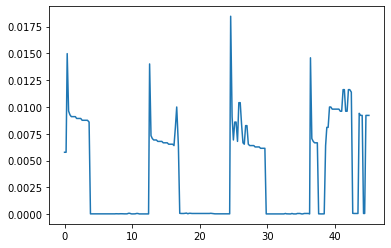

In [21]:
plt.plot(df.gnss.t-df.gnss.t[0], df.gnss.cov_x)

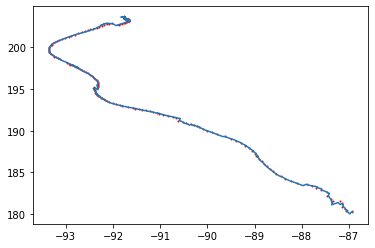

In [22]:
plt.plot(df.ekf.px, df.ekf.py)
plt.scatter(df.gnss.x, df.gnss.y, s=1.0, color='red')

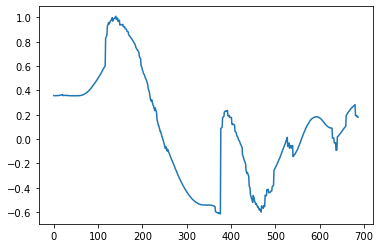

In [11]:
plt.plot(df.cs.error_yaw)

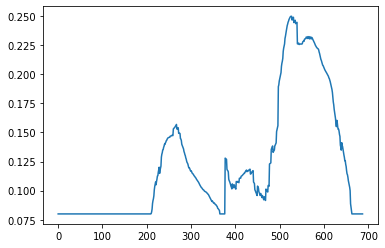

In [12]:
plt.plot(df.cs.action_throttle)

In [ ]:
cs_e_lat = df.cs.error_lateral.values
cs_e_yaw = df.cs.error_yaw.values
cs_speed = df.cs.actual_speed.values
cs_s = cs_e_yaw + np.arctan2(1.0*cs_e_lat, 1.0 + cs_speed)
cs_s = cs_s * 180. / np.pi * (-1)
cs_s[cs_s <= -35.] = -35.
cs_s[cs_s >= 28.] = 28.
plt.plot(df.cs.action_steer)
plt.plot(cs_s)

In [ ]:
plt.plot(df.cs.t, df.cs.action_steer)
plt.plot(df.ar.t, df.ar.steering_angle)